In [1]:
# Import Detectron2 should be installed in your local computer. https://detectron2.readthedocs.io/en/latest/tutorials/install.html
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
#Register the dataset and metadata for the model.
#the dataset are the files used for the training, testing, and validation used. No need for all 3 to run.

from detectron2.data.datasets import register_coco_instances
register_coco_instances("3class_train", {}, "./ncfiles3/labels_clasestres_2022-07-26-01-21-07.json", "./ncfiles3/files")
#register_coco_instances("3class_val", {}, "./labels_clasestres_2022-07-26-01-21-07.json", "./3class/valid")
#register_coco_instances("3class_test", {}, "./labels_clasestres_2022-07-26-01-21-07.json", "./3class/test")

[07/29 12:03:17 d2.data.datasets.coco]: Loaded 65 images in COCO format from ./ncfiles3/labels_clasestres_2022-07-26-01-21-07.json


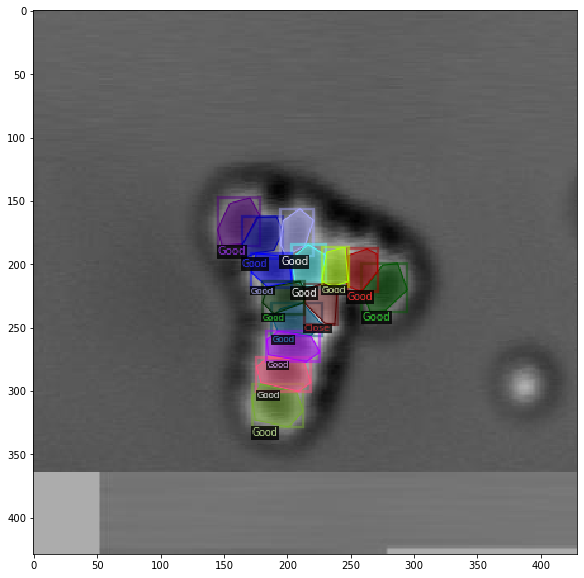

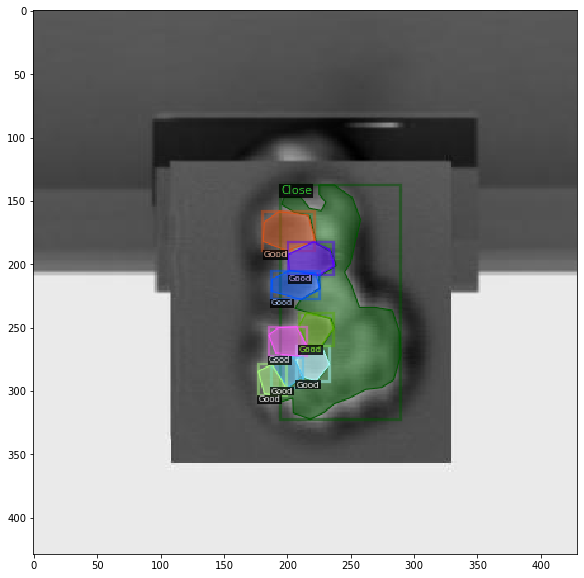

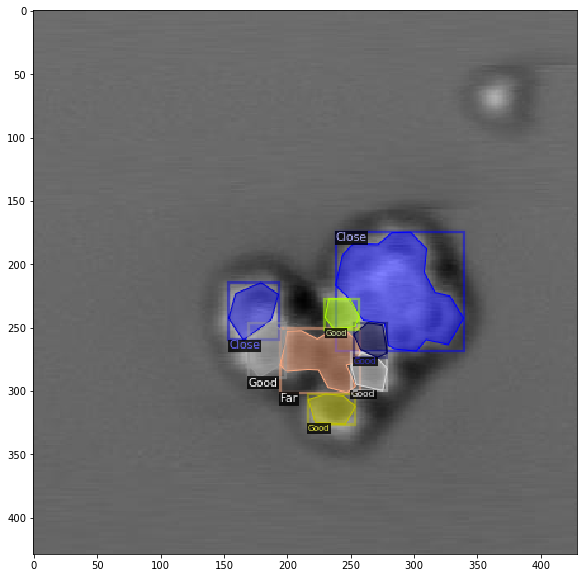

In [3]:
#Check To see that the files/labels are uploaded correctlly on 3 random files. 
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("3class_train")
microcontroller_metadata = MetadataCatalog.get("3class_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=1.3,instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
#Check the metadata to see what is labeled.
microcontroller_metadata 

Metadata(evaluator_type='coco', image_root='./ncfiles3/files', json_file='./ncfiles3/labels_clasestres_2022-07-26-01-21-07.json', name='3class_train', thing_classes=['Close', 'Far', 'Good'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

In [5]:
#Get Config Files and Trainer. 

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #Pick your favorite from model zoo
cfg.DATASETS.TRAIN = ("3class_train",) # comes from the file registered above
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")#Pick your favorite from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #Change depending on how many classes you have. Some lablers add an extra class, so double check

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#Uncomment below to train model. Leave commented to just load the config file

#trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

In [6]:
# Load weights from model and decide on Threshold. Run predictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("3class_train", )
predictor = DefaultPredictor(cfg)

[07/28 09:55:32 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [1]:
#Run model on one specific File

from detectron2.utils.visualizer import ColorMode
#dataset_dicts = DatasetCatalog.get("ring_test")
#print(dataset_dicts)
#dataset_dicts = "Ringers"
#for d in random.sample(dataset_dicts, 3):    
im = cv2.imread("CUT.png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=microcontroller_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (20, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'cv2' is not defined

In [ ]:
#Run on multiple files in a specifi directory. 

from detectron2.utils.visualizer import ColorMode


microcontroller_metadata = MetadataCatalog.get("3class_train")
for filename in os.listdir("./"):
    if (filename.endswith(".jpg")):
        #text = np.load(filename)
        im = cv2.imread(filename)
        #print(im)
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                        metadata=microcontroller_metadata,
                        scale=1.2, 
                        instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize = (14, 10))
        plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()
        #cv2.imwrite('result_'+filename+'',v.get_image()[:, :, ::-1])  #uncomment to Save file if you want

[07/28 11:02:48 d2.data.datasets.coco]: Loaded 65 images in COCO format from ./ncfiles3/labels_clasestres_2022-07-26-01-21-07.json


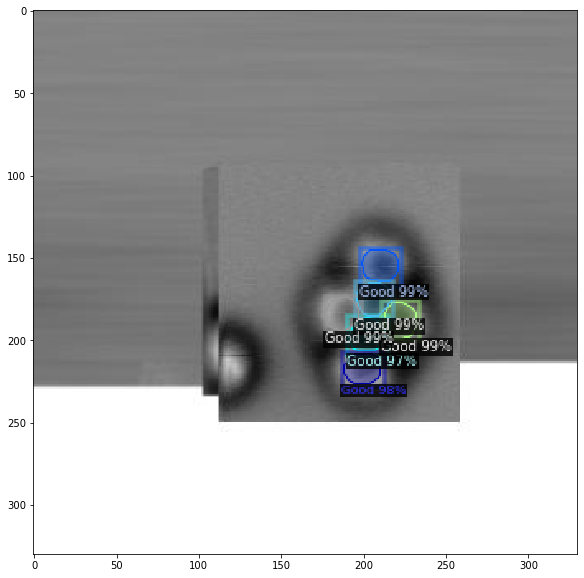

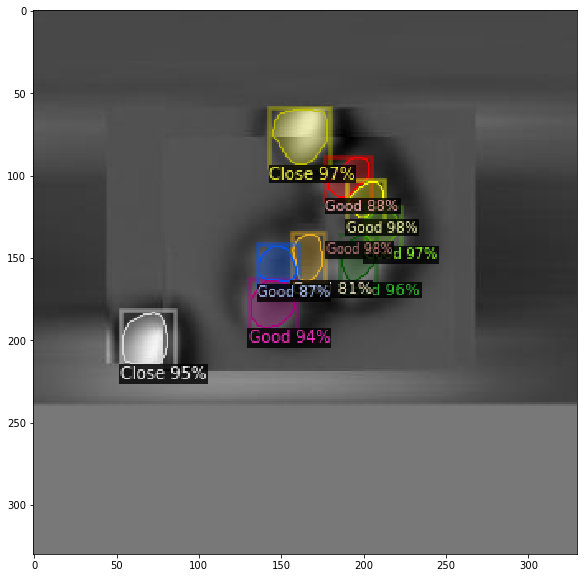

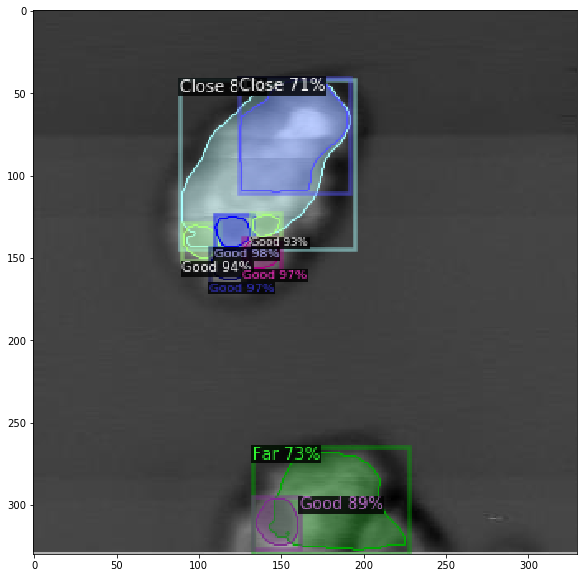

In [98]:
#Run model on 3 random files in your dataset if registered. Typically used on validation or test. With a bigger dataset. 
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("3class_train") #Used on train here to double check.
#print(dataset_dicts)
#dataset_dicts = "Ringers"
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [99]:
#outputs all the information given by the model on a given file or the last file it ran on. Not sure how to see this for all files at once yet. 
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs["instances"])


tensor([2, 2, 2, 2, 2, 2, 0, 1, 0], device='cuda:0')
Boxes(tensor([[109.5478, 124.2007, 132.6800, 144.9234],
        [127.0829, 137.6011, 150.0876, 157.9562],
        [106.8202, 144.4902, 131.0723, 165.5361],
        [ 90.2541, 129.0950, 112.9107, 152.2728],
        [132.3137, 122.6611, 150.4870, 138.2052],
        [132.6440, 295.4710, 161.8638, 327.3300],
        [ 88.7187,  41.7698, 195.3167, 145.3925],
        [132.5546, 264.5620, 227.6004, 330.0000],
        [124.9882,  41.1612, 192.3998, 110.7173]], device='cuda:0'))
Instances(num_instances=9, image_height=330, image_width=330, fields=[pred_boxes: Boxes(tensor([[109.5478, 124.2007, 132.6800, 144.9234],
        [127.0829, 137.6011, 150.0876, 157.9562],
        [106.8202, 144.4902, 131.0723, 165.5361],
        [ 90.2541, 129.0950, 112.9107, 152.2728],
        [132.3137, 122.6611, 150.4870, 138.2052],
        [132.6440, 295.4710, 161.8638, 327.3300],
        [ 88.7187,  41.7698, 195.3167, 145.3925],
        [132.5546, 264.5620, 227.6

In [144]:
#Visualize the ouputs as a mask. Different than the one detectron2 uses.

mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
num_instances = mask_array.shape[0]
scores = outputs['instances'].scores.to("cpu").numpy()
labels = outputs['instances'].pred_classes .to("cpu").numpy()
bbox   = outputs['instances'].pred_boxes.to("cpu").tensor.numpy()

mask_array = np.moveaxis(mask_array, 0, -1)

mask_array_instance = []
#img = np.zeros_like(im) #black
h = im.shape[0]
w = im.shape[1]
img_mask = np.zeros([h, w, 3], np.uint8)
for i in range(num_instances):
    if labels[i]==0:
        color = (250, 43, 138)
    elif labels[i]==1:
        color = (0, 0, 255)
    else:
        color = (0,255,0)
    img = np.zeros_like(im)
    mask_array_instance.append(mask_array[:, :, i:(i+1)])
    img = np.where(mask_array_instance[i] == True, 255, img)
    array_img = np.asarray(img)
    img_mask[np.where((array_img==[255,255,255]).all(axis=2))]=color
    
img_mask = np.asarray(img_mask)
output = cv2.addWeighted(im, 0.7, img_mask, 0.3, 0)

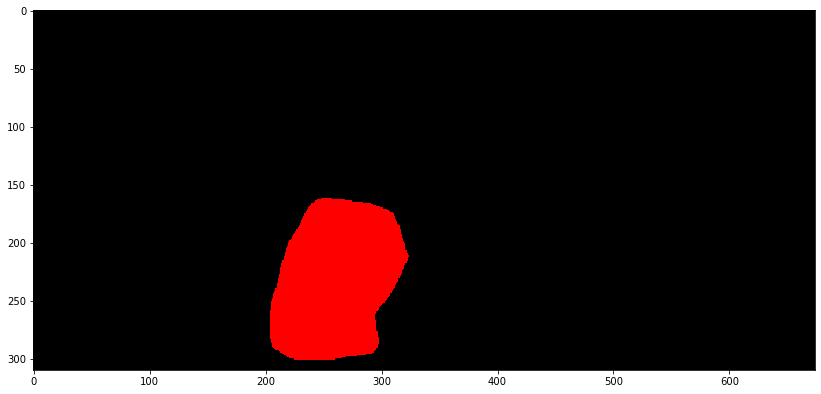

True

In [145]:
#See mask produced.
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('result.jpg',img_mask)

In [146]:
#Remove black background from files. 

import cv2
file_name = "result.jpg"

src = cv2.imread(file_name, 1)
tmp = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
_,alpha = cv2.threshold(tmp,25,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(src)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)
cv2.imwrite("test.png", dst)


True

In [25]:
#Load Tensorboard if you want to see how model is working
#%load_ext tensorboard
#%tensorboard --logdir output